## Введение

В работе исследуются контрастивный метод SimCLR и неконтрастивный метод VICReg для обучения представлений на рентгеновских изображениях грудной клетки из датасетов ChestMNIST и PneumoniaMNIST из набора MedMNIST+. 

В качестве базового энкодера используется модифицированный ResNet‑18, а качество полученных представлений оценивается с помощью линейного пробинга как на этапе подбора аугментаций (online probing), так и после полного предобучения (offline linear probing).

## Аугментации

Для обоих датасетов выполнен первичный анализ: изучено количество объектов в классах, дисбаланс классов, формат разметки (multi‑label и бинарная классификация), а также распределения значений пикселей; на основе этого выбрана метрика ROC‑AUC и функции потерь (BCE с весами классов для несбалансированных задач). 

Аугментации подбирались с учётом специфики CXR‑изображений: были ослаблены цветовые преобразования по сравнению с стандартным набором для ImageNet, добавлены небольшие повороты и инверсия, а также проведено сравнение собственного набора аугментаций с референсным, предложенным в задании. Подробнее можно почитать в [EDA.ipynb](EDA.ipynb).

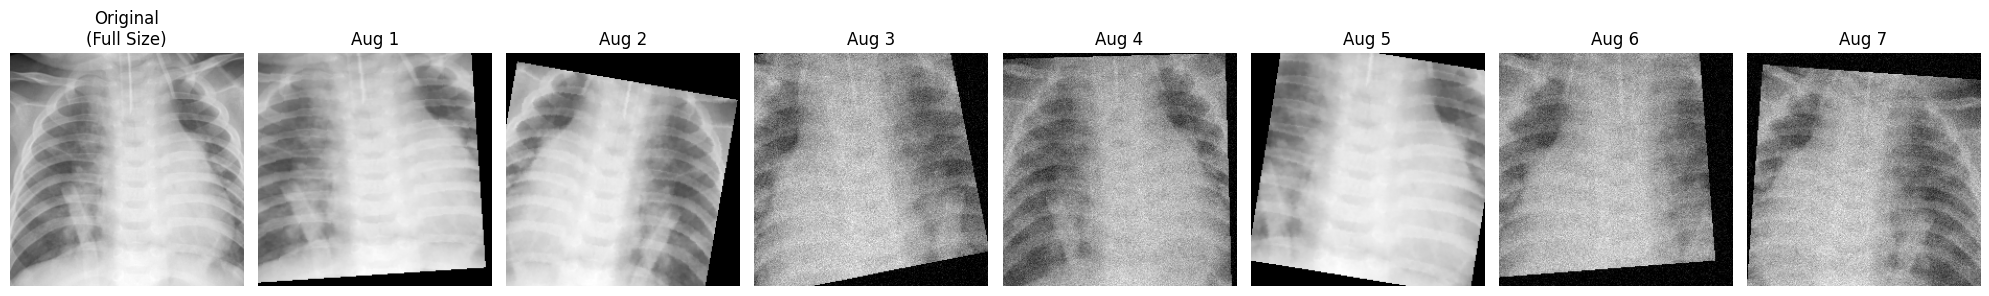

## Методы и реализация

В работе реализованы два метода SSL обучения представлений:

**SimCLR** — контрастивный метод, использующий Normalized Temperature-scaled Cross Entropy loss для максимизации схожести между аугментированными версиями одного изображения и минимизации схожести между разными изображениями. Архитектура включает ResNet-18 энкодер и проекционную голову. Для оптимизации применяется LARS оптимизатор с Linear Warmup Cosine Annealing scheduler и начальным learning rate 0.3.

**VICReg** — неконтрастивный метод, основанный на регуляризации трёх компонент: Variance (сохранение дисперсии представлений), Invariance (схожесть аугментаций одного объекта) и Covariance (декорреляция признаков). Использует аналогичный энкодер, но с большей проекционной головой, что важно для эффективной работы метода.

Для ускорения подбора гиперпараметров применён **online probing**: параллельно с SSL-обучением к энкодеру добавляется линейная голова для классификации, обучаемая на тех же данных с ground truth разметкой. Градиенты от классификационной задачи не проходят через энкодер, что позволяет оценивать качество представлений в реальном времени без затрат на полный цикл offline linear probing.

Графики обучения на трех типах аугментации, которые я рассматривал:

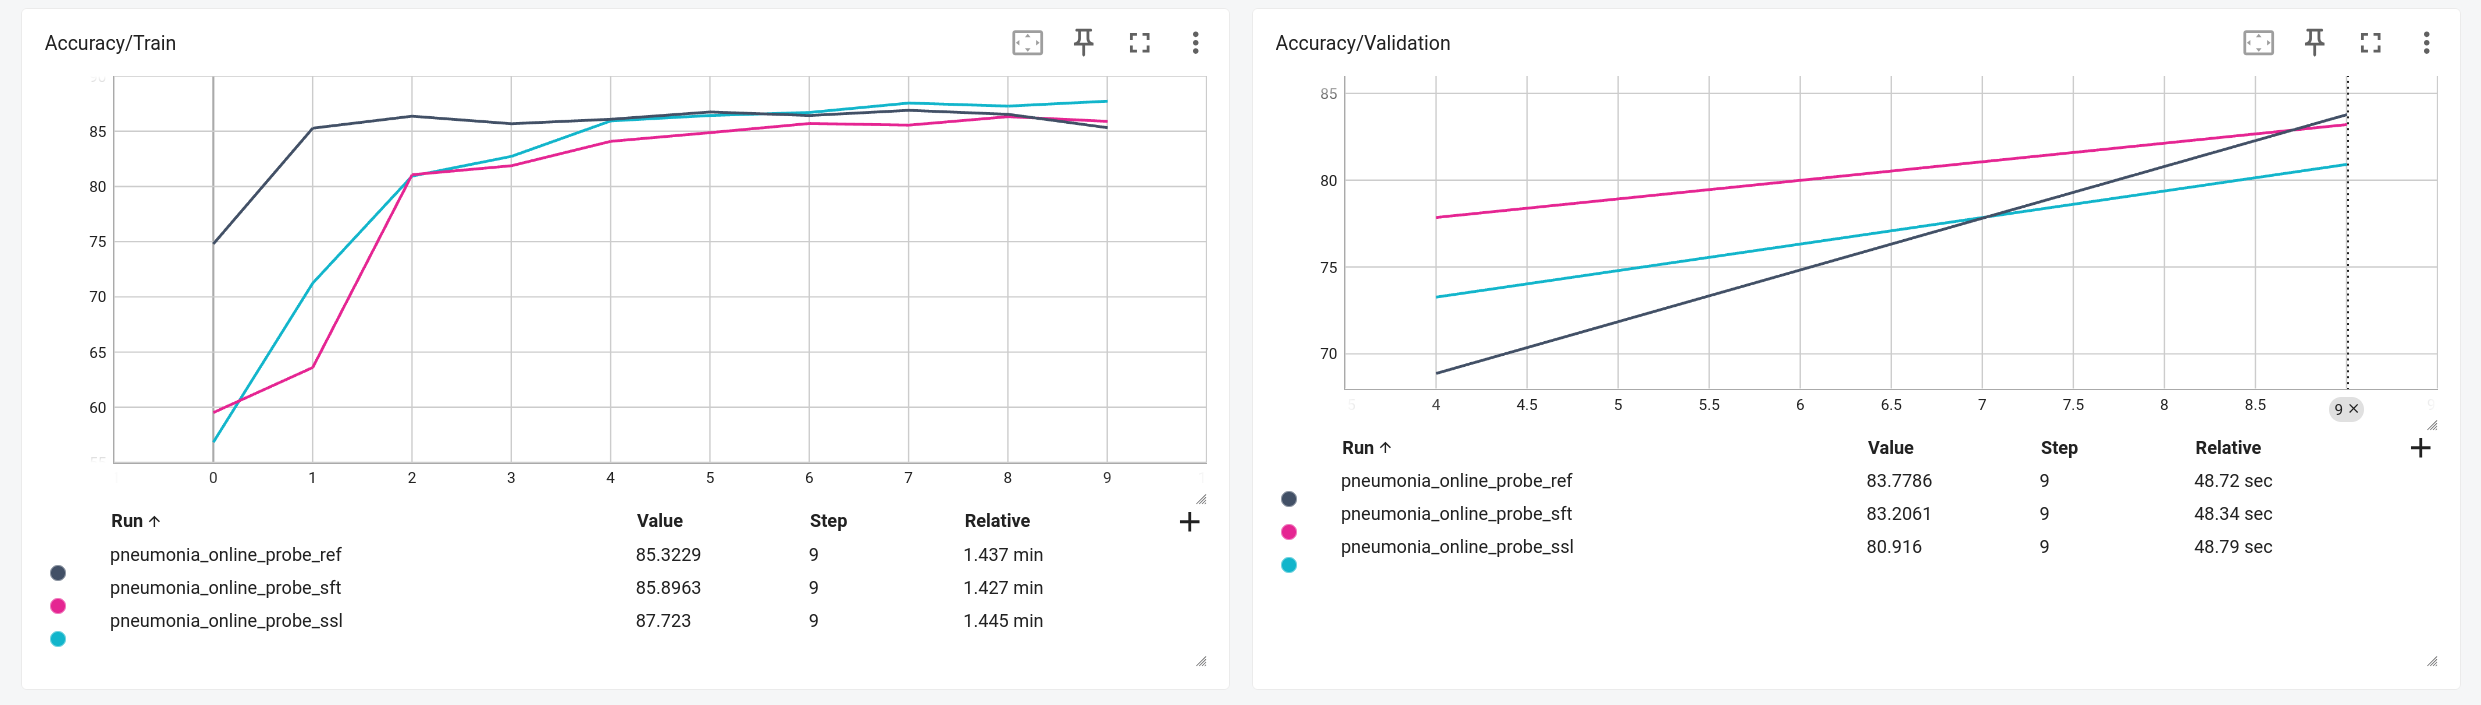

Кривые обучения для VicReg и SimCLR для оффлайн линейных проб после полного предобучения на датасете.

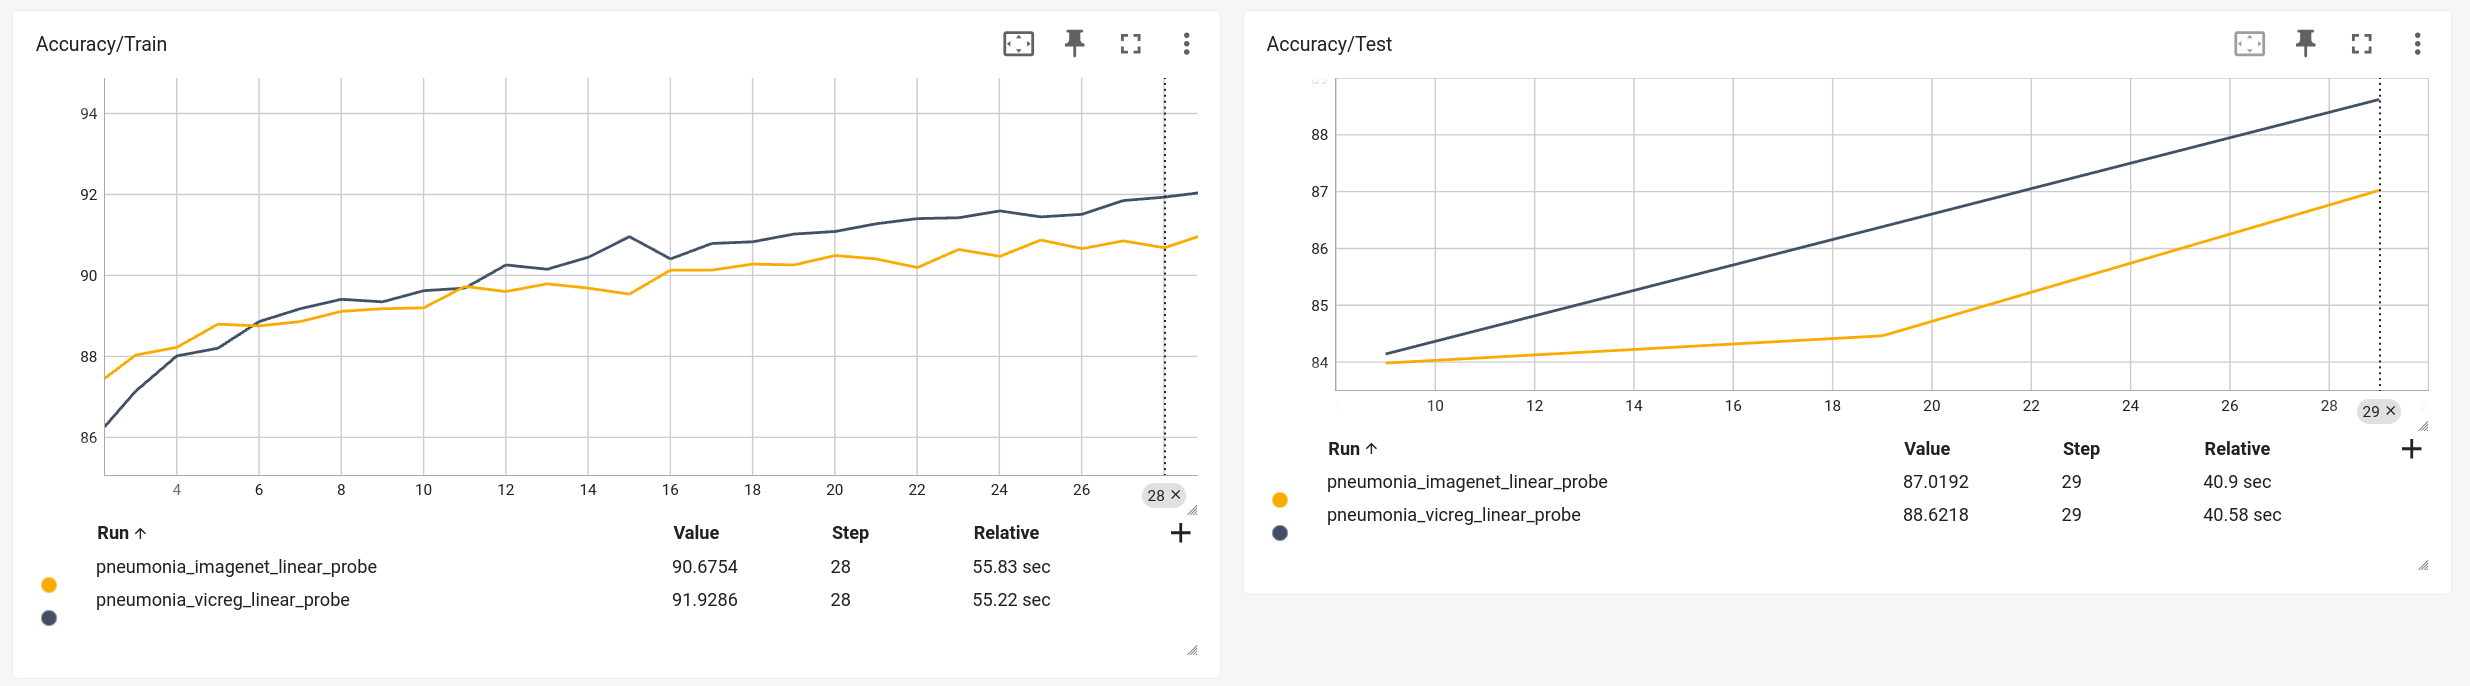

## Результаты

### Подбор аугментаций (Online Probing, 10 эпох)

Сравнение трёх наборов аугментаций на PneumoniaMNIST показало:

- **ref** (референсный набор): ROC-AUC ~91.00% на валидации
- **ssl** (собственный набор): ROC-AUC ~92.10% на валидации 
- **sft** (soft augmentations): ROC-AUC ~92.11% на валидации

Мой собственный набор аугментаций (ssl) показал лучше результаты, чем референсный, что подтверждает корректность выбора трансформаций для медицинских изображений. Обе конфигурации выбранных мной аугментаций превосходят исходный набор, демонстрируя важность правильного подбора аугментаций для CXR-изображений.

### Полное предобучение (50 эпох) и offline linear probing (30 эпох)

После предобучения на 50 эпохах с лучшим набором аугментаций (ssl) и последующего линейного пробинга получены следующие результаты на PneumoniaMNIST:

| Метод | ROC-AUC (Test) | Относительное качество |
|-------|----------------|------------------------|
| **SimCLR** (random init) | **90.68%** | Baseline |
| **VICReg** (random init) | **91.93%** | +1.25% |
| **SimCLR** (ImageNet init) | **87.02%** | -3.66% |

**VICReg показал лучшие результаты** (+1.25% ROC-AUC), что согласуется с его преимуществами: отсутствие необходимости в больших батчах (критично для SimCLR), отсутствие negative pairs и более стабильная оптимизация. Неконтрастивный подход оказался более эффективным для относительно небольшого датасета PneumoniaMNIST (5,856 samples).

### Влияние инициализации с ImageNet весами

Неожиданно, **инициализация с ImageNet весов ухудшила результаты** (-3.66% по сравнению со случайной инициализацией). Это объясняется значительным domain gap между естественными RGB изображениями и медицинскими рентгеновскими снимками: признаки, полезные для ImageNet (текстуры, цвета, объекты), не переносятся эффективно на задачу анализа плотности тканей в CXR. Random initialization позволяет модели с нуля адаптироваться под специфику медицинского домена, если использовать предобучение без учителя и обучать поверх линейную пробу.

### Сравнение с Supervised подходом

Согласно [MedMNIST benchmarks](https://medmnist.com/), supervised ResNet-18 достигает на PneumoniaMNIST ROC-AUC около 96.3%. Наши SSL методы достигли ~90-92% без использования разметки на этапе предобучения, что не так плохо, учитывая что мы учим один линейный слой вместо всей модели.

## Заключение

Исследование подтвердило эффективность SSL методов для медицинских изображений при правильном подборе аугментаций. VICReg превзошёл SimCLR на небольшом датасете. Online probing показал себя эффективным инструментом для быстрой итерации по гиперпараметрам. Domain-specific аугментации и random initialization оказались критичными для достижения высокого качества на CXR-изображениях.